# KMeans Classifier

The idea is to classify users in to clusters based on their movie preferences. The user will than have to select movies and rate them. Based on the ratings a classification will happen and movies which users in this class like watching will be recommended

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv('./movies-database/ml-25m/ratings.csv')
movies = pd.read_csv('./movies-database/ml-25m/movies.csv')

ratings = pd.merge(ratings,movies, on='movieId', how='inner')

In [3]:
active_users = ratings.groupby('userId').size().reset_index(name='count')
active_users = active_users.sort_values(by='count', ascending=False)
active_users = active_users.head(5000)

In [4]:
popular_movies = ratings.groupby('movieId').size().reset_index(name='count')
popular_movies = popular_movies.sort_values(by='count', ascending=False)
popular_movies = popular_movies.head(10000)

In [5]:

ratings = ratings[ratings['userId'].isin(active_users['userId']) & ratings['movieId'].isin(popular_movies['movieId'])]


user_item_matrix = ratings.pivot_table(index='userId', columns='title', values='rating', fill_value=0)

In [6]:
user_item_matrix

title   "Great Performances" Cats (1998)  '71 (2014)  'Round Midnight (1986)  \
userId                                                                         
12                                   0.0         0.0                     0.0   
72                                   0.0         0.0                     0.0   
187                                  0.0         0.0                     0.0   
321                                  0.0         0.0                     0.0   
426                                  0.0         2.5                     0.0   
...                                  ...         ...                     ...   
162445                               0.0         0.0                     0.0   
162484                               0.0         0.0                     0.0   
162495                               0.0         0.0                     0.0   
162508                               0.0         0.0                     0.0   
162516                               0.0         0.0                     2.5   

title   'Salem's Lot (2004)  'Til There Was You (1997)  'burbs, The (1989)  \
userId                                                                       
12                      0.0                        0.0                 0.0   
72                      0.0                        0.0                 3.0   
187                     0.0                        0.0                 0.0   
321                     0.0                        0.0                 3.5   
426                     0.0                        0.0                 0.0   
...                     ...                        ...                 ...   
162445                  0.0                        0.0                 0.0   
162484                  0.0                        0.0                 0.0   
162495                  0.0                        0.0                 3.5   
162508                  0.0                        0.0                 0.0   
162516                  0.0                        0.0                 0.0   

title   'night Mother (1986)  (500) Days of Summer (2009)  \
userId                                                      
12                       0.0                          3.0   
72                       0.0                          0.0   
187                      0.0                          4.0   
321                      0.0                          0.0   
426                      0.0                          0.0   
...                      ...                          ...   
162445                   3.0                          0.0   
162484                   0.0                          0.0   
162495                   0.0                          0.0   
162508                   0.0                          2.5   
162516                   0.0                          4.0   

title   *batteries not included (1987)  ...And Justice for All (1979)  ...  \
userId                                                                 ...   
12                                 0.0                            0.0  ...   
72                                 0.0                            0.0  ...   
187                                0.0                            0.0  ...   
321                                0.0                            0.0  ...   
426                                0.0                            0.0  ...   
...                                ...                            ...  ...   
162445                             0.0                            0.0  ...   
162484                             0.0                            0.0  ...   
162495                             3.5                            0.0  ...   
162508                             0.0                            0.0  ...   
162516                             3.0                            3.0  ...   

title   [REC]² (2009)  [REC]³ 3 Génesis (2012)  eXistenZ (1999)  iBoy (2017)  \
userId                                                 

In [7]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
user_item_matrix['cluster'] = kmeans.fit_predict(user_item_matrix)


clusters created. Now looking for movies with best entropy splitting

In [8]:
import numpy as np
import pandas as pd

# Function to compute entropy from a value distribution
def entropy(probs):
    return -np.sum([p * np.log2(p) for p in probs if p > 0])

# Compute overall cluster entropy
cluster_probs = user_item_matrix['cluster'].value_counts(normalize=True)
overall_entropy = entropy(cluster_probs)

# Binning function for ratings
def bin_rating(r):
    if r == 0:
        return 'none'
    elif r < 2.5:
        return 'low'
    elif r < 3.5:
        return 'mid'
    else:
        return 'high'
    

# Store results
info_gains = []

# Remove 'cluster' column for iteration
matrix = user_item_matrix.drop(columns='cluster')
clusters = user_item_matrix['cluster']

for movie in matrix.columns:
    # Create a Series with binned ratings
    bins = matrix[movie].apply(bin_rating)

    bin_entropy = 0
    total = len(bins)

    for b in ['none', 'low', 'mid', 'high']:
        idx = bins[bins == b].index
        if len(idx) == 0:
            continue
        weight = len(idx) / total
        cluster_dist = clusters.loc[idx].value_counts(normalize=True)
        bin_entropy += weight * entropy(cluster_dist)

    info_gain = overall_entropy - bin_entropy
    info_gains.append((movie, info_gain))

In [14]:
# Sort descending by info gain
info_gains.sort(key=lambda x: x[1], reverse=True)

# Show top 10
for movie, gain in info_gains[:10]:
    print(f"Movie ID {movie:<6} Info Gain: {gain:.4f}")
    
movie_id_to_title = dict(zip(movies['movieId'], movies['title']))
for movie, gain in info_gains[:10]:
    title = movie_id_to_title.get(movie, 'Unknown')
    print(f"{title:<50} Info Gain: {gain:.4f}")

Movie ID Player, The (1992) Info Gain: 0.1613
Movie ID Bonnie and Clyde (1967) Info Gain: 0.1603
Movie ID Chinatown (1974) Info Gain: 0.1550
Movie ID Annie Hall (1977) Info Gain: 0.1450
Movie ID Graduate, The (1967) Info Gain: 0.1450
Movie ID Manchurian Candidate, The (1962) Info Gain: 0.1440
Movie ID Maltese Falcon, The (1941) Info Gain: 0.1436
Movie ID Grifters, The (1990) Info Gain: 0.1434
Movie ID Citizen Kane (1941) Info Gain: 0.1425
Movie ID North by Northwest (1959) Info Gain: 0.1421
Unknown                                            Info Gain: 0.1613
Unknown                                            Info Gain: 0.1603
Unknown                                            Info Gain: 0.1550
Unknown                                            Info Gain: 0.1450
Unknown                                            Info Gain: 0.1450
Unknown                                            Info Gain: 0.1440
Unknown                                            Info Gain: 0.1436
Unknown              

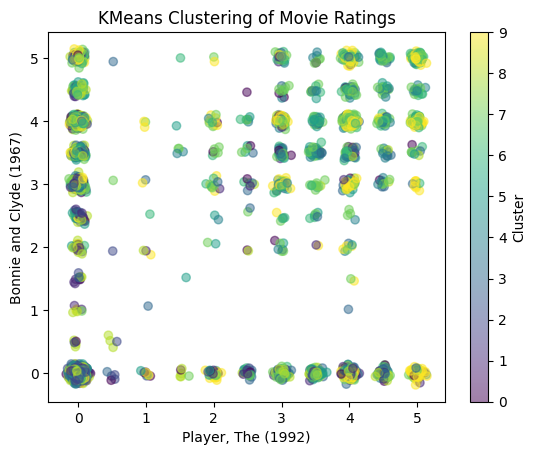

In [10]:
jitterX = np.random.normal(0, 0.05, size=user_item_matrix.shape[0])
jitterY = np.random.normal(0, 0.05, size=user_item_matrix.shape[0])

movie1 = 'Player, The (1992)'
movie2 = 'Bonnie and Clyde (1967)'


plt.scatter(user_item_matrix[movie1]  + jitterX, user_item_matrix[movie2]+jitterY, c=user_item_matrix['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel(movie1)
plt.ylabel(movie2)
plt.title('KMeans Clustering of Movie Ratings')
plt.colorbar(label='Cluster')